# Assignment 5 part 2

# Task 1

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sn
import pandas as pd
import time
import os
import copy

# Import data from Google Drive

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_dir = '/content/drive/My Drive/Colab Notebooks/Assignment 5 part2/A_05_Part_02_Dataset'

#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(15),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
val_data = datasets.ImageFolder(data_dir + '/Validation', transform=val_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


# Display a batch from Validation data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


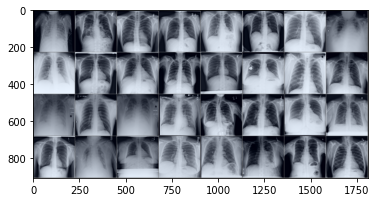

pneumonia pneumonia pneumonia normal pneumonia normal normal pneumonia normal normal normal normal normal normal normal pneumonia pneumonia normal pneumonia pneumonia normal normal normal pneumonia normal pneumonia normal normal normal pneumonia normal normal


In [0]:
# functions to show an image
def imshow(img):
    img = img * 0.22 + 0.45     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(valloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))

# Load pre-trained VGG16 model and replace the FC layers

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
num_features = vgg16.classifier[0].in_features

fc = nn.Sequential(
            nn.Linear(num_features, 220), # used same FC layers as in Assignment 5 part 1
            nn.ReLU(True),
            nn.Linear(220, 3)
        )
vgg16.classifier = fc
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Train the VGG16 model on our dataset with Cross Entropy loss

In [0]:
def one_hot_encode(labels):
    one_hot = torch.zeros(labels.size(0), 3)
    i = 0
    for x in labels:
        if x == 0:
            one_hot[i] = torch.tensor([1, 1, 0])
        elif x == 2:
            one_hot[i] = torch.tensor([0, 1, 0])
        else:
            one_hot[i] = torch.tensor([0, 0, 1])
        i += 1
    return one_hot

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
sig = nn.Sigmoid()

In [0]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

val_loss = list()
val_f1 = list()
train_loss = list()
train_f1 = list()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_precision = 0.0
    running_recall = 0.0
    running_f1 = 0.0
    running_loss = 0.0
    samples = 0
    
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        labels = one_hot_encode(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)     #----> compute loss
        loss.backward()                       #----> backward pass
        optimizer.step()                      #----> weights update

        #compute training precision, recall, f1-score
        outputs = sig(outputs.data)
        predictions = torch.round(outputs)    # ------> applies threshold at 0.5/
        p, r, f1,_ = precision_recall_fscore_support(labels.data.to('cpu'), predictions.data.to('cpu'), average='samples', zero_division=1)
        
        running_precision += p
        running_recall += r
        running_f1 += f1
        running_loss += loss.item()
        samples += len(inputs)

        # print statistics
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}\tF1: {:.4f}'.format(
                epoch, samples, len(trainloader.dataset),
                100. * i / len(trainloader),
                running_loss/(i+1), running_precision/(i+1), running_recall/(i+1), running_f1/(i+1)))
    
    train_loss.append(running_loss/(i+1))
    train_f1.append(running_f1/(i+1))
    
    running_precision_val = 0.0
    running_recall_val = 0.0
    running_f1_val = 0.0
    running_loss_val = 0.0
    batches = 0
    
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            labels = one_hot_encode(labels)
            images, labels = images.to(device), labels.to(device)
            
            outputs = vgg16(images)
            loss = criterion(outputs, labels)
            outputs = sig(outputs.data)
            predictions = torch.round(outputs)   # ------> applies threshold at 0.5/
            
            p, r, f1,_ = precision_recall_fscore_support(labels.data.to('cpu'), predictions.data.to('cpu'), average='samples', zero_division=1)
        
            running_precision_val += p
            running_recall_val += r
            running_f1_val += f1
            running_loss_val += loss.item()
            batches += 1
            
    val_loss.append(running_loss_val/batches)
    val_f1.append(running_f1_val/batches)

val_precision = running_precision_val/batches
val_recall = running_recall_val/batches

print('Finished Training')
torch.save(vgg16.state_dict(), F'/content/drive/My Drive/Colab Notebooks/Assignment 5 part2/vgg16_Cross_Entropy.pth')

Train Epoch: 0 [6200/6200 (99%)]	Loss: 0.2405	Precision: 0.8760	Recall: 0.8636	F1: 0.8638: : 194it [04:13,  1.31s/it]
Train Epoch: 1 [6200/6200 (99%)]	Loss: 0.1656	Precision: 0.9235	Recall: 0.9118	F1: 0.9133: : 194it [04:13,  1.31s/it]
Train Epoch: 2 [6200/6200 (99%)]	Loss: 0.1450	Precision: 0.9322	Recall: 0.9229	F1: 0.9235: : 194it [04:14,  1.31s/it]
Train Epoch: 3 [6200/6200 (99%)]	Loss: 0.1301	Precision: 0.9404	Recall: 0.9349	F1: 0.9349: : 194it [04:14,  1.31s/it]
Train Epoch: 4 [6200/6200 (99%)]	Loss: 0.1156	Precision: 0.9441	Recall: 0.9395	F1: 0.9398: : 194it [04:15,  1.32s/it]
Train Epoch: 5 [6200/6200 (99%)]	Loss: 0.1082	Precision: 0.9497	Recall: 0.9448	F1: 0.9447: : 194it [04:16,  1.32s/it]
Train Epoch: 6 [6200/6200 (99%)]	Loss: 0.1091	Precision: 0.9489	Recall: 0.9452	F1: 0.9446: : 194it [04:17,  1.33s/it]
Train Epoch: 7 [6200/6200 (99%)]	Loss: 0.0974	Precision: 0.9552	Recall: 0.9517	F1: 0.9515: : 194it [04:14,  1.31s/it]
Train Epoch: 8 [6200/6200 (99%)]	Loss: 0.0927	Precision:

Finished Training


# Plot F1 Score and Loss curves

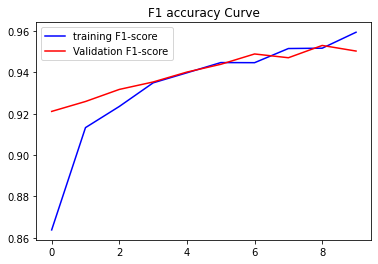

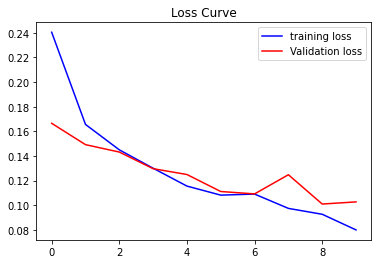

In [0]:
#F1 curve
plt.subplots()
plt.plot(train_f1, 'b', label = 'training F1-score')
plt.plot(val_f1, 'r', label = 'Validation F1-score')
plt.title("F1 accuracy Curve")
plt.legend()
plt.show()

#loss curve
plt.subplots()
plt.plot(np.array(train_loss), 'b', label = 'training loss')
plt.plot(np.array(val_loss), 'r', label = 'Validation loss')
plt.title("Loss Curve")
plt.legend()
plt.show()

# Precision, Recall and F1 score

In [0]:
print("Training Precision: {:.2f}%".format(100*running_precision/(i+1)))
print("Training Recall:    {:.2f}%".format(100*running_recall/(i+1)))
print("Training F1-score:  {:.2f}%".format(100*train_f1[-1]))

print("\nValidation Precision: {:.2f}%".format(100*val_precision))
print("Validation Recall:    {:.2f}%".format(100*val_recall))
print("Validation F1-score:  {:.2f}%".format(100*val_f1[-1]))

Training Precision: 96.37%
Training Recall:    95.95%
Training F1-score:  95.94%

Validation Precision: 95.11%
Validation Recall:    95.34%
Validation F1-score:  95.03%


# Training confusion matrix

Training Confusion matrices:



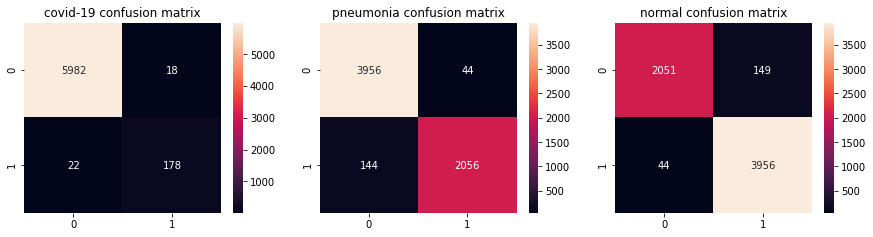

In [0]:
m = np.zeros((3,2,2))
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        labels = one_hot_encode(labels)
        images, labels = images.to(device), labels.to(device)
        
        outputs = vgg16(images)
        outputs = sig(outputs.data)
        predictions = torch.round(outputs)   # ------> applies threshold at 0.5/
        m += multilabel_confusion_matrix(labels.data.to('cpu'), predictions.data.to('cpu'))

matrix0 = pd.DataFrame(m[0], ['0', '1'], ['0', '1'])
matrix1 = pd.DataFrame(m[1], ['0', '1'], ['0', '1'])
matrix2 = pd.DataFrame(m[2], ['0', '1'], ['0', '1'])

print("Training Confusion matrices:\n")
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,3.5))
sn.heatmap(matrix0, annot=True, ax=ax1, fmt='g')
ax1.set_title('covid-19 confusion matrix')
sn.heatmap(matrix1, annot=True, ax=ax2, fmt='g')
ax2.set_title('pneumonia confusion matrix')
sn.heatmap(matrix2, annot=True, ax=ax3, fmt='g')
ax3.set_title('normal confusion matrix')
plt.show()

# Validation confusion matrix

Validation Confusion matrices:



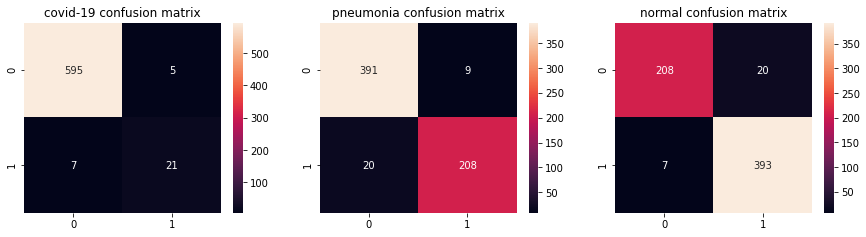

In [0]:
m = np.zeros((3,2,2))
with torch.no_grad():
    for data in valloader:
        images, labels = data
        labels = one_hot_encode(labels)
        images, labels = images.to(device), labels.to(device)
        
        outputs = vgg16(images)
        outputs = sig(outputs.data)
        predictions = torch.round(outputs)   # ------> applies threshold at 0.5/
        m += multilabel_confusion_matrix(labels.data.to('cpu'), predictions.data.to('cpu'))

matrix0 = pd.DataFrame(m[0], ['0', '1'], ['0', '1'])
matrix1 = pd.DataFrame(m[1], ['0', '1'], ['0', '1'])
matrix2 = pd.DataFrame(m[2], ['0', '1'], ['0', '1'])

print("Validation Confusion matrices:\n")
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,3.5))
sn.heatmap(matrix0, annot=True, ax=ax1, fmt='g')
ax1.set_title('covid-19 confusion matrix')
sn.heatmap(matrix1, annot=True, ax=ax2, fmt='g')
ax2.set_title('pneumonia confusion matrix')
sn.heatmap(matrix2, annot=True, ax=ax3, fmt='g')
ax3.set_title('normal confusion matrix')
plt.show()

# Load pre-trained ResNet-18 model and replace the FC layers

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
num_features = resnet18.fc.in_features

my_fc = nn.Sequential(
            nn.Linear(num_features, 220), # used same FC layers as in Assignment 5 part 1
            nn.ReLU(True),
            nn.Linear(220, 3)
        )
resnet18.fc = my_fc
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Train the ResNet18 model on our dataset with Cross Entropy loss

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
sig = nn.Sigmoid()

In [0]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()

val_loss = list()
val_f1 = list()
train_loss = list()
train_f1 = list()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_precision = 0.0
    running_recall = 0.0
    running_f1 = 0.0
    running_loss = 0.0
    samples = 0
    
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        labels = one_hot_encode(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)     #----> compute loss
        loss.backward()                       #----> backward pass
        optimizer.step()                      #----> weights update

        #compute training precision, recall, f1-score
        outputs = sig(outputs.data)
        predictions = torch.round(outputs)    # ------> applies threshold at 0.5/
        p, r, f1,_ = precision_recall_fscore_support(labels.data.to('cpu'), predictions.data.to('cpu'), average='samples', zero_division=1)
        
        running_precision += p
        running_recall += r
        running_f1 += f1
        running_loss += loss.item()
        samples += len(inputs)

        # print statistics
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}\tF1: {:.4f}'.format(
                epoch, samples, len(trainloader.dataset),
                100. * i / len(trainloader),
                running_loss/(i+1), running_precision/(i+1), running_recall/(i+1), running_f1/(i+1)))
    
    train_loss.append(running_loss/(i+1))
    train_f1.append(running_f1/(i+1))
    
    running_precision_val = 0.0
    running_recall_val = 0.0
    running_f1_val = 0.0
    running_loss_val = 0.0
    batches = 0
    
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            labels = one_hot_encode(labels)
            images, labels = images.to(device), labels.to(device)
            
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            outputs = sig(outputs.data)
            predictions = torch.round(outputs)   # ------> applies threshold at 0.5/
            
            p, r, f1,_ = precision_recall_fscore_support(labels.data.to('cpu'), predictions.data.to('cpu'), average='samples', zero_division=1)
        
            running_precision_val += p
            running_recall_val += r
            running_f1_val += f1
            running_loss_val += loss.item()
            batches += 1
            
    val_loss.append(running_loss_val/batches)
    val_f1.append(running_f1_val/batches)

val_precision = running_precision_val/batches
val_recall = running_recall_val/batches

print('Finished Training')
torch.save(vgg16.state_dict(), F'/content/drive/My Drive/Colab Notebooks/Assignment 5 part2/resnet18_Cross_Entropy.pth')

Train Epoch: 0 [6200/6200 (99%)]	Loss: 0.3736	Precision: 0.7740	Recall: 0.7580	F1: 0.7516: : 194it [02:49,  1.14it/s]
Train Epoch: 1 [6200/6200 (99%)]	Loss: 0.2115	Precision: 0.9036	Recall: 0.8894	F1: 0.8923: : 194it [02:48,  1.15it/s]
Train Epoch: 2 [6200/6200 (99%)]	Loss: 0.1756	Precision: 0.9201	Recall: 0.9061	F1: 0.9092: : 194it [02:48,  1.15it/s]
Train Epoch: 3 [6200/6200 (99%)]	Loss: 0.1659	Precision: 0.9244	Recall: 0.9092	F1: 0.9127: : 194it [02:48,  1.15it/s]
Train Epoch: 4 [6200/6200 (99%)]	Loss: 0.1569	Precision: 0.9291	Recall: 0.9125	F1: 0.9163: : 194it [02:48,  1.15it/s]
Train Epoch: 5 [6200/6200 (99%)]	Loss: 0.1467	Precision: 0.9321	Recall: 0.9174	F1: 0.9208: : 194it [02:48,  1.15it/s]
Train Epoch: 6 [6200/6200 (99%)]	Loss: 0.1388	Precision: 0.9398	Recall: 0.9238	F1: 0.9274: : 194it [02:48,  1.15it/s]
Train Epoch: 7 [6200/6200 (99%)]	Loss: 0.1284	Precision: 0.9402	Recall: 0.9277	F1: 0.9309: : 194it [02:48,  1.15it/s]
Train Epoch: 8 [6200/6200 (99%)]	Loss: 0.1195	Precision:

Finished Training


# Plot F1 Score and Loss curves

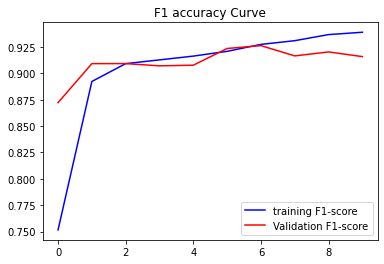

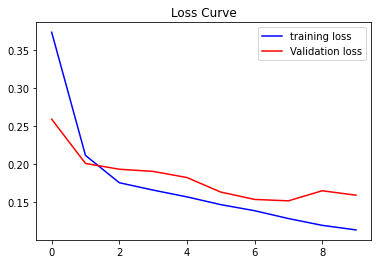

In [0]:
#F1 curve
plt.subplots()
plt.plot(train_f1, 'b', label = 'training F1-score')
plt.plot(val_f1, 'r', label = 'Validation F1-score')
plt.title("F1 accuracy Curve")
plt.legend()
plt.show()

#loss curve
plt.subplots()
plt.plot(np.array(train_loss), 'b', label = 'training loss')
plt.plot(np.array(val_loss), 'r', label = 'Validation loss')
plt.title("Loss Curve")
plt.legend()
plt.show()

# Precision, Recall and F1 score

In [0]:
print("Training Precision: {:.2f}%".format(100*running_precision/(i+1)))
print("Training Recall:    {:.2f}%".format(100*running_recall/(i+1)))
print("Training F1-score:  {:.2f}%".format(100*train_f1[-1]))

print("\nValidation Precision: {:.2f}%".format(100*val_precision))
print("Validation Recall:    {:.2f}%".format(100*val_recall))
print("Validation F1-score:  {:.2f}%".format(100*val_f1[-1]))

Training Precision: 94.59%
Training Recall:    93.72%
Training F1-score:  93.89%

Validation Precision: 92.47%
Validation Recall:    91.45%
Validation F1-score:  91.58%


# Training confusion matrix

Training Confusion matrices:



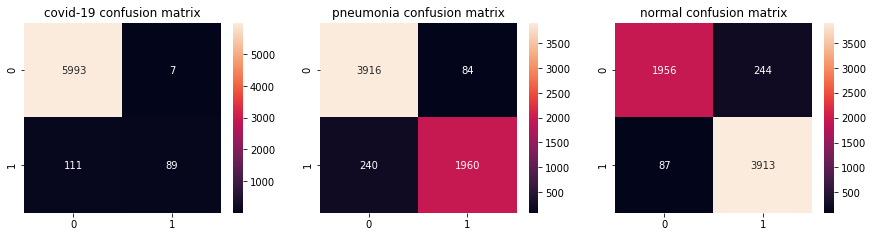

In [0]:
m = np.zeros((3,2,2))
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        labels = one_hot_encode(labels)
        images, labels = images.to(device), labels.to(device)
        
        outputs = resnet18(images)
        outputs = sig(outputs.data)
        predictions = torch.round(outputs)   # ------> applies threshold at 0.5/
        m += multilabel_confusion_matrix(labels.data.to('cpu'), predictions.data.to('cpu'))

matrix0 = pd.DataFrame(m[0], ['0', '1'], ['0', '1'])
matrix1 = pd.DataFrame(m[1], ['0', '1'], ['0', '1'])
matrix2 = pd.DataFrame(m[2], ['0', '1'], ['0', '1'])

print("Training Confusion matrices:\n")
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,3.5))
sn.heatmap(matrix0, annot=True, ax=ax1, fmt='g')
ax1.set_title('covid-19 confusion matrix')
sn.heatmap(matrix1, annot=True, ax=ax2, fmt='g')
ax2.set_title('pneumonia confusion matrix')
sn.heatmap(matrix2, annot=True, ax=ax3, fmt='g')
ax3.set_title('normal confusion matrix')
plt.show()

# Validation confusion matrix

Validation Confusion matrices:



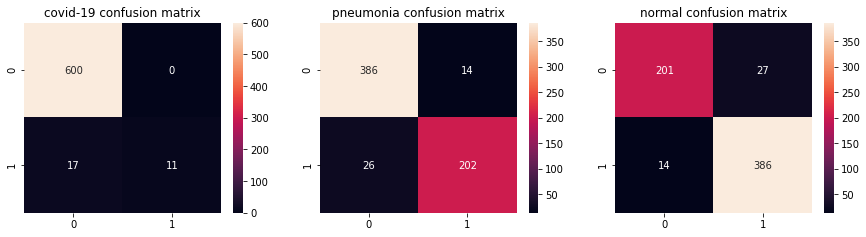

In [0]:
m = np.zeros((3,2,2))
with torch.no_grad():
    for data in valloader:
        images, labels = data
        labels = one_hot_encode(labels)
        images, labels = images.to(device), labels.to(device)
        
        outputs = resnet18(images)
        outputs = sig(outputs.data)
        predictions = torch.round(outputs)   # ------> applies threshold at 0.5/
        m += multilabel_confusion_matrix(labels.data.to('cpu'), predictions.data.to('cpu'))

matrix0 = pd.DataFrame(m[0], ['0', '1'], ['0', '1'])
matrix1 = pd.DataFrame(m[1], ['0', '1'], ['0', '1'])
matrix2 = pd.DataFrame(m[2], ['0', '1'], ['0', '1'])

print("Validation Confusion matrices:\n")
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,3.5))
sn.heatmap(matrix0, annot=True, ax=ax1, fmt='g')
ax1.set_title('covid-19 confusion matrix')
sn.heatmap(matrix1, annot=True, ax=ax2, fmt='g')
ax2.set_title('pneumonia confusion matrix')
sn.heatmap(matrix2, annot=True, ax=ax3, fmt='g')
ax3.set_title('normal confusion matrix')
plt.show()

# **Task 2**

# Load pre-trained VGG16 model and replace the FC layers

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
num_features = vgg16.classifier[0].in_features

fc = nn.Sequential(
            nn.Linear(num_features, 220), # used same FC layers as in Assignment 5 part 1
            nn.ReLU(True),
            nn.Linear(220, 3)
        )
vgg16.classifier = fc
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Train the VGG16 model on our dataset with Focal loss

In [0]:
BCE = nn.BCEWithLogitsLoss()
def focal_loss (outputs, labels, alpha=1, gamma=0):
    log_pt = BCE(outputs, labels)
    pt = torch.exp(-log_pt)
    penalty = alpha * (1-pt)**gamma
    penalized_loss = penalty * log_pt
    mean_loss = torch.mean(penalized_loss)
    return mean_loss

In [0]:
Epochs = 25
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
sig = nn.Sigmoid()

In [10]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

val_loss = list()
val_f1 = list()
train_loss = list()
train_f1 = list()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_precision = 0.0
    running_recall = 0.0
    running_f1 = 0.0
    running_loss = 0.0
    samples = 0
    
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        labels = one_hot_encode(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)                                     #----> forward pass
        loss = focal_loss(outputs, labels, alpha=0.25, gamma=2)     #----> compute focal loss
        loss.backward()                                             #----> backward pass
        optimizer.step()                                            #----> weights update

        #compute training precision, recall, f1-score
        outputs = sig(outputs.data)
        predictions = torch.round(outputs)                          # ------> applies threshold at 0.5/
        p, r, f1,_ = precision_recall_fscore_support(labels.data.to('cpu'), predictions.data.to('cpu'), average='samples', zero_division=1)
        
        running_precision += p
        running_recall += r
        running_f1 += f1
        running_loss += loss.item()
        samples += len(inputs)

        # print statistics
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}\tF1: {:.4f}'.format(
                epoch, samples, len(trainloader.dataset),
                100. * i / len(trainloader),
                running_loss/(i+1), running_precision/(i+1), running_recall/(i+1), running_f1/(i+1)))
    
    train_loss.append(running_loss/(i+1))
    train_f1.append(running_f1/(i+1))
    
    running_precision_val = 0.0
    running_recall_val = 0.0
    running_f1_val = 0.0
    running_loss_val = 0.0
    batches = 0
    
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            labels = one_hot_encode(labels)
            images, labels = images.to(device), labels.to(device)
            
            outputs = vgg16(images)
            loss = focal_loss(outputs, labels, alpha=0.25, gamma=2) 
            outputs = sig(outputs.data)
            predictions = torch.round(outputs)   # ------> applies threshold at 0.5/
            
            p, r, f1,_ = precision_recall_fscore_support(labels.data.to('cpu'), predictions.data.to('cpu'), average='samples', zero_division=1)
        
            running_precision_val += p
            running_recall_val += r
            running_f1_val += f1
            running_loss_val += loss.item()
            batches += 1
            
    val_loss.append(running_loss_val/batches)
    val_f1.append(running_f1_val/batches)

val_precision = running_precision_val/batches
val_recall = running_recall_val/batches

print('Finished Training')
torch.save(vgg16.state_dict(), F'/content/drive/My Drive/Colab Notebooks/Assignment 5 part2/vgg16_focal_loss.pth')

Train Epoch: 0 [6200/6200 (99%)]	Loss: 0.0115	Precision: 0.7737	Recall: 0.7487	F1: 0.7431: : 194it [03:09,  1.02it/s]
Train Epoch: 1 [6200/6200 (99%)]	Loss: 0.0045	Precision: 0.8705	Recall: 0.8589	F1: 0.8574: : 194it [03:08,  1.03it/s]
Train Epoch: 2 [6200/6200 (99%)]	Loss: 0.0033	Precision: 0.8818	Recall: 0.8667	F1: 0.8675: : 194it [03:07,  1.03it/s]
Train Epoch: 3 [6200/6200 (99%)]	Loss: 0.0027	Precision: 0.8963	Recall: 0.8801	F1: 0.8810: : 194it [03:06,  1.04it/s]
Train Epoch: 4 [6200/6200 (99%)]	Loss: 0.0023	Precision: 0.9012	Recall: 0.8848	F1: 0.8856: : 194it [03:06,  1.04it/s]
Train Epoch: 5 [6200/6200 (99%)]	Loss: 0.0021	Precision: 0.9071	Recall: 0.8922	F1: 0.8925: : 194it [03:06,  1.04it/s]
Train Epoch: 6 [6200/6200 (99%)]	Loss: 0.0019	Precision: 0.9135	Recall: 0.8980	F1: 0.8997: : 194it [03:04,  1.05it/s]
Train Epoch: 7 [6200/6200 (99%)]	Loss: 0.0016	Precision: 0.9181	Recall: 0.9022	F1: 0.9033: : 194it [03:06,  1.04it/s]
Train Epoch: 8 [6200/6200 (99%)]	Loss: 0.0016	Precision:

Finished Training


# Plot F1 Score and Loss curves

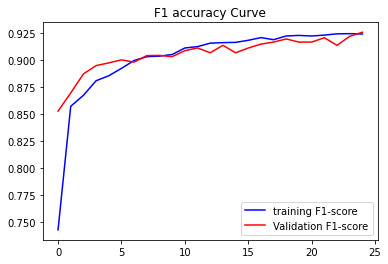

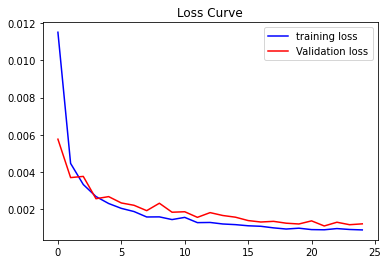

In [11]:
#F1 curve
plt.subplots()
plt.plot(train_f1, 'b', label = 'training F1-score')
plt.plot(val_f1, 'r', label = 'Validation F1-score')
plt.title("F1 accuracy Curve")
plt.legend()
plt.show()

#loss curve
plt.subplots()
plt.plot(np.array(train_loss), 'b', label = 'training loss')
plt.plot(np.array(val_loss), 'r', label = 'Validation loss')
plt.title("Loss Curve")
plt.legend()
plt.show()

# Precision, Recall and F1 score

In [12]:
print("Training Precision: {:.2f}%".format(100*running_precision/(i+1)))
print("Training Recall:    {:.2f}%".format(100*running_recall/(i+1)))
print("Training F1-score:  {:.2f}%".format(100*train_f1[-1]))

print("\nValidation Precision: {:.2f}%".format(100*val_precision))
print("Validation Recall:    {:.2f}%".format(100*val_recall))
print("Validation F1-score:  {:.2f}%".format(100*val_f1[-1]))

Training Precision: 93.45%
Training Recall:    92.38%
Training F1-score:  92.42%

Validation Precision: 93.42%
Validation Recall:    92.52%
Validation F1-score:  92.58%


# Training confusion matrix

Training Confusion matrices:



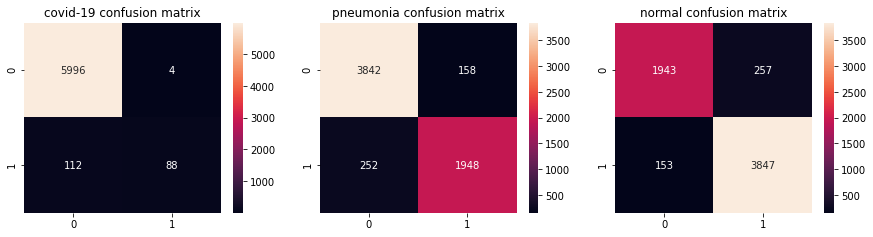

In [13]:
m = np.zeros((3,2,2))
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        labels = one_hot_encode(labels)
        images, labels = images.to(device), labels.to(device)
        
        outputs = vgg16(images)
        outputs = sig(outputs.data)
        predictions = torch.round(outputs)   # ------> applies threshold at 0.5/
        m += multilabel_confusion_matrix(labels.data.to('cpu'), predictions.data.to('cpu'))

matrix0 = pd.DataFrame(m[0], ['0', '1'], ['0', '1'])
matrix1 = pd.DataFrame(m[1], ['0', '1'], ['0', '1'])
matrix2 = pd.DataFrame(m[2], ['0', '1'], ['0', '1'])

print("Training Confusion matrices:\n")
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,3.5))
sn.heatmap(matrix0, annot=True, ax=ax1, fmt='g')
ax1.set_title('covid-19 confusion matrix')
sn.heatmap(matrix1, annot=True, ax=ax2, fmt='g')
ax2.set_title('pneumonia confusion matrix')
sn.heatmap(matrix2, annot=True, ax=ax3, fmt='g')
ax3.set_title('normal confusion matrix')
plt.show()

# Validation confusion matrix

Validation Confusion matrices:



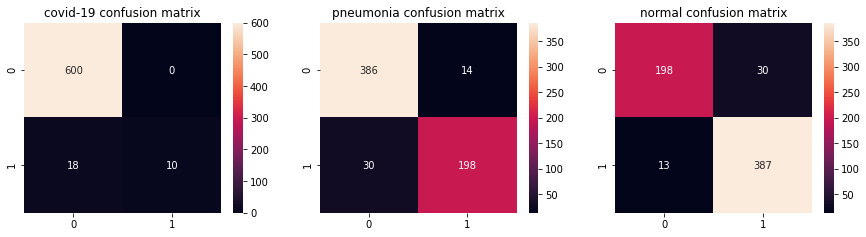

In [14]:
m = np.zeros((3,2,2))
with torch.no_grad():
    for data in valloader:
        images, labels = data
        labels = one_hot_encode(labels)
        images, labels = images.to(device), labels.to(device)
        
        outputs = vgg16(images)
        outputs = sig(outputs.data)
        predictions = torch.round(outputs)   # ------> applies threshold at 0.5/
        m += multilabel_confusion_matrix(labels.data.to('cpu'), predictions.data.to('cpu'))

matrix0 = pd.DataFrame(m[0], ['0', '1'], ['0', '1'])
matrix1 = pd.DataFrame(m[1], ['0', '1'], ['0', '1'])
matrix2 = pd.DataFrame(m[2], ['0', '1'], ['0', '1'])

print("Validation Confusion matrices:\n")
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,3.5))
sn.heatmap(matrix0, annot=True, ax=ax1, fmt='g')
ax1.set_title('covid-19 confusion matrix')
sn.heatmap(matrix1, annot=True, ax=ax2, fmt='g')
ax2.set_title('pneumonia confusion matrix')
sn.heatmap(matrix2, annot=True, ax=ax3, fmt='g')
ax3.set_title('normal confusion matrix')
plt.show()

# Load pre-trained ResNet-18 model and replace the FC layers

In [18]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
num_features = resnet18.fc.in_features

my_fc = nn.Sequential(
            nn.Linear(num_features, 220), # used same FC layers as in Assignment 5 part 1
            nn.ReLU(True),
            nn.Linear(220, 3)
        )
resnet18.fc = my_fc
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Train the ResNet18 model on our dataset with Focal loss

In [0]:
Epochs = 25
optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)
sig = nn.Sigmoid()

In [20]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()

val_loss = list()
val_f1 = list()
train_loss = list()
train_f1 = list()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_precision = 0.0
    running_recall = 0.0
    running_f1 = 0.0
    running_loss = 0.0
    samples = 0
    
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        labels = one_hot_encode(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)                                     #----> forward pass
        loss = focal_loss(outputs, labels, alpha=0.25, gamma=2)     #----> compute focal loss
        loss.backward()                                             #----> backward pass
        optimizer.step()                                            #----> weights update

        #compute training precision, recall, f1-score
        outputs = sig(outputs.data)
        predictions = torch.round(outputs)                          # ------> applies threshold at 0.5/
        p, r, f1,_ = precision_recall_fscore_support(labels.data.to('cpu'), predictions.data.to('cpu'), average='samples', zero_division=1)
        
        running_precision += p
        running_recall += r
        running_f1 += f1
        running_loss += loss.item()
        samples += len(inputs)

        # print statistics
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}\tF1: {:.4f}'.format(
                epoch, samples, len(trainloader.dataset),
                100. * i / len(trainloader),
                running_loss/(i+1), running_precision/(i+1), running_recall/(i+1), running_f1/(i+1)))
    
    train_loss.append(running_loss/(i+1))
    train_f1.append(running_f1/(i+1))
    
    running_precision_val = 0.0
    running_recall_val = 0.0
    running_f1_val = 0.0
    running_loss_val = 0.0
    batches = 0
    
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            labels = one_hot_encode(labels)
            images, labels = images.to(device), labels.to(device)
            
            outputs = resnet18(images)
            loss = focal_loss(outputs, labels, alpha=0.25, gamma=2) 
            outputs = sig(outputs.data)
            predictions = torch.round(outputs)   # ------> applies threshold at 0.5/
            
            p, r, f1,_ = precision_recall_fscore_support(labels.data.to('cpu'), predictions.data.to('cpu'), average='samples', zero_division=1)
        
            running_precision_val += p
            running_recall_val += r
            running_f1_val += f1
            running_loss_val += loss.item()
            batches += 1
            
    val_loss.append(running_loss_val/batches)
    val_f1.append(running_f1_val/batches)

val_precision = running_precision_val/batches
val_recall = running_recall_val/batches

print('Finished Training')
torch.save(vgg16.state_dict(), F'/content/drive/My Drive/Colab Notebooks/Assignment 5 part2/resnet18_focal_loss.pth')

Train Epoch: 0 [6200/6200 (99%)]	Loss: 0.0114	Precision: 0.7664	Recall: 0.7646	F1: 0.7572: : 194it [02:45,  1.17it/s]
Train Epoch: 1 [6200/6200 (99%)]	Loss: 0.0037	Precision: 0.8804	Recall: 0.8691	F1: 0.8702: : 194it [02:46,  1.16it/s]
Train Epoch: 2 [6200/6200 (99%)]	Loss: 0.0025	Precision: 0.9001	Recall: 0.8871	F1: 0.8891: : 194it [02:47,  1.16it/s]
Train Epoch: 3 [6200/6200 (99%)]	Loss: 0.0023	Precision: 0.9072	Recall: 0.8947	F1: 0.8969: : 194it [02:47,  1.16it/s]
Train Epoch: 4 [6200/6200 (99%)]	Loss: 0.0019	Precision: 0.9148	Recall: 0.9011	F1: 0.9036: : 194it [02:47,  1.16it/s]
Train Epoch: 5 [6200/6200 (99%)]	Loss: 0.0016	Precision: 0.9167	Recall: 0.9007	F1: 0.9042: : 194it [02:47,  1.16it/s]
Train Epoch: 6 [6200/6200 (99%)]	Loss: 0.0014	Precision: 0.9225	Recall: 0.9080	F1: 0.9113: : 194it [02:49,  1.14it/s]
Train Epoch: 7 [6200/6200 (99%)]	Loss: 0.0014	Precision: 0.9266	Recall: 0.9122	F1: 0.9157: : 194it [02:58,  1.08it/s]
Train Epoch: 8 [6200/6200 (99%)]	Loss: 0.0013	Precision:

Finished Training


# Plot F1 Score and Loss curves

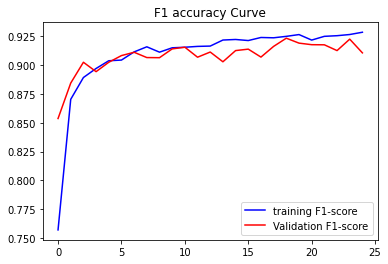

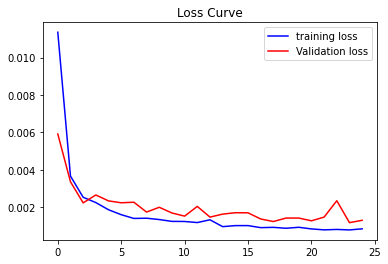

In [21]:
#F1 curve
plt.subplots()
plt.plot(train_f1, 'b', label = 'training F1-score')
plt.plot(val_f1, 'r', label = 'Validation F1-score')
plt.title("F1 accuracy Curve")
plt.legend()
plt.show()

#loss curve
plt.subplots()
plt.plot(np.array(train_loss), 'b', label = 'training loss')
plt.plot(np.array(val_loss), 'r', label = 'Validation loss')
plt.title("Loss Curve")
plt.legend()
plt.show()

# Precision, Recall and F1 score

In [22]:
print("Training Precision: {:.2f}%".format(100*running_precision/(i+1)))
print("Training Recall:    {:.2f}%".format(100*running_recall/(i+1)))
print("Training F1-score:  {:.2f}%".format(100*train_f1[-1]))

print("\nValidation Precision: {:.2f}%".format(100*val_precision))
print("Validation Recall:    {:.2f}%".format(100*val_recall))
print("Validation F1-score:  {:.2f}%".format(100*val_f1[-1]))

Training Precision: 93.93%
Training Recall:    92.44%
Training F1-score:  92.83%

Validation Precision: 92.30%
Validation Recall:    90.53%
Validation F1-score:  91.04%


# Training confusion matrix

Training Confusion matrices:



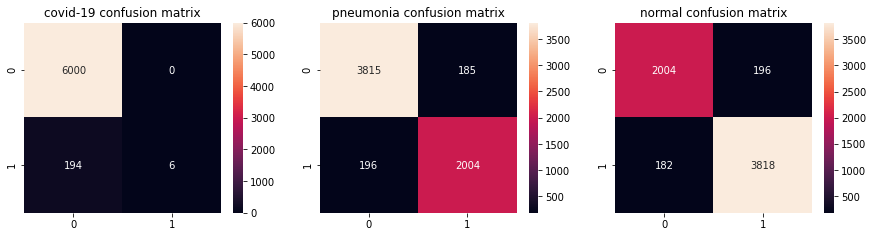

In [23]:
m = np.zeros((3,2,2))
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        labels = one_hot_encode(labels)
        images, labels = images.to(device), labels.to(device)
        
        outputs = resnet18(images)
        outputs = sig(outputs.data)
        predictions = torch.round(outputs)   # ------> applies threshold at 0.5/
        m += multilabel_confusion_matrix(labels.data.to('cpu'), predictions.data.to('cpu'))

matrix0 = pd.DataFrame(m[0], ['0', '1'], ['0', '1'])
matrix1 = pd.DataFrame(m[1], ['0', '1'], ['0', '1'])
matrix2 = pd.DataFrame(m[2], ['0', '1'], ['0', '1'])

print("Training Confusion matrices:\n")
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,3.5))
sn.heatmap(matrix0, annot=True, ax=ax1, fmt='g')
ax1.set_title('covid-19 confusion matrix')
sn.heatmap(matrix1, annot=True, ax=ax2, fmt='g')
ax2.set_title('pneumonia confusion matrix')
sn.heatmap(matrix2, annot=True, ax=ax3, fmt='g')
ax3.set_title('normal confusion matrix')
plt.show()

# Validation confusion matrix

Validation Confusion matrices:



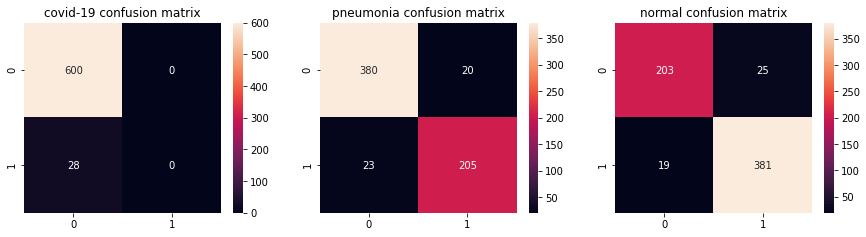

In [24]:
m = np.zeros((3,2,2))
with torch.no_grad():
    for data in valloader:
        images, labels = data
        labels = one_hot_encode(labels)
        images, labels = images.to(device), labels.to(device)
        
        outputs = resnet18(images)
        outputs = sig(outputs.data)
        predictions = torch.round(outputs)   # ------> applies threshold at 0.5/
        m += multilabel_confusion_matrix(labels.data.to('cpu'), predictions.data.to('cpu'))

matrix0 = pd.DataFrame(m[0], ['0', '1'], ['0', '1'])
matrix1 = pd.DataFrame(m[1], ['0', '1'], ['0', '1'])
matrix2 = pd.DataFrame(m[2], ['0', '1'], ['0', '1'])

print("Validation Confusion matrices:\n")
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,3.5))
sn.heatmap(matrix0, annot=True, ax=ax1, fmt='g')
ax1.set_title('covid-19 confusion matrix')
sn.heatmap(matrix1, annot=True, ax=ax2, fmt='g')
ax2.set_title('pneumonia confusion matrix')
sn.heatmap(matrix2, annot=True, ax=ax3, fmt='g')
ax3.set_title('normal confusion matrix')
plt.show()

# Predict Test set results
Based on results from all the models and analyzing the confusin matrices I have concluded that my best results were for VGG-16 without focal loss.

In [0]:
# apply data transform
test_data = datasets.ImageFolder(data_dir + '/Test', transform=val_transforms)

# data loader
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

In [53]:
# load vgg model
vgg16 = models.vgg16(pretrained=True)
num_features = vgg16.classifier[0].in_features

fc = nn.Sequential(
            nn.Linear(num_features, 220), # used same FC layers as in Assignment 5 part 1
            nn.ReLU(True),
            nn.Linear(220, 3)
        )
vgg16.classifier = fc
vgg16.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/Assignment 5 part2/vgg16_Cross_Entropy.pth'))

<All keys matched successfully>

In [0]:
i = 0
results = list()
vgg16.to(device)
for data in testloader:
    images, labels = data
    images = images.to(device)

    outputs = vgg16(images)
    outputs = sig(outputs.data)
    predictions = torch.round(outputs)   # ------> applies threshold at 0.5/
    predicted_labels = predictions.to('cpu').numpy().astype(int)[0]

    row = [os.path.basename(testloader.dataset.samples[i][0]), predicted_labels[0], predicted_labels[1], predicted_labels[2]]
    results.append(row)
    i += 1

In [0]:
import csv
with open('/content/drive/My Drive/Colab Notebooks/Assignment 5 part2/MSDS19012_results.csv','w') as results_file:
    csv_writer = csv.writer(results_file)
    for row in results:
        csv_writer.writerow(row)
